<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2022/blob/main/11/PTE_DL11_Subwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Mit tartalmaz egy (al)szó?

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l09c06_nlp_subwords.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l09c06_nlp_subwords.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Ebben a munkafüzetben alszavakkal, vagyis nagyobb szavak darabjaiból álló szavakkal fogunk dolgozni, és megnézzük, hogy ez hogyan befolyásolja a hálózatunkat és a kapcsolódó beágyazásokat.

## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

## Az eredeti adathalmaz letöltése

Ismét az Amazon és a Yelp értékeléseit tartalmazó adathalmazt fogjuk használni. Ez az adatkészlet eredetileg a [itt](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set) oldalról származik.

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O sentiment.csv

--2022-11-23 13:16:39--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 142.251.10.138, 142.251.10.139, 142.251.10.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.10.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p9qe9nl5r8og5kf0dfv9qrrborfesubu/1669209375000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=2f6f4f5e-3844-4bb8-99b5-27e44d4036c6 [following]
--2022-11-23 13:16:39--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p9qe9nl5r8og5kf0dfv9qrrborfesubu/1669209375000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=2f6f4f5e-3844-4bb8-99b5-27e44d4036c6
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 142.250.4.132, 2404:6800:4003:c06::84
Connecting to doc-08-

In [3]:
import pandas as pd

dataset = pd.read_csv('sentiment.csv')

# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

## Hozzunk létre egy subwords adathalmazt

A meglévő Amazon és Yelp értékelések adathalmazt használhatjuk a `tensorflow_datasets` `SubwordTextEncoder` funkciójával. A `SubwordTextEncoder.build_from_corpus()` létrehoz nekünk egy tokenizálót. Ezt a funkcionalitást használhatnánk arra is, hogy egy sokkal nagyobb szövegkorpuszból is kapjunk alszavakat, de mi itt csak a meglévő adathalmazunkat fogjuk használni.

Az Amazon és a Yelp általunk használt adathalmaza nem túl nagy, ezért csak az 1000 leggyakoribb szóból fogunk létrehozni egy `vocab_size` alszót, valamint minden alszót úgy vágunk le, hogy az legfeljebb 5 karakter legyen.


In [4]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

In [7]:
# Check that the tokenizer works appropriately
num = 6
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

If you have several dozen or several hundred contacts then imagine the fun of sending each of them one by one.
[364, 39, 31, 69, 500, 775, 197, 293, 38, 117, 69, 500, 775, 399, 123, 475, 775, 79, 62, 86, 3, 506, 241, 683, 557, 775, 1, 429, 38, 15, 69, 123, 26, 210, 232, 15, 507, 80, 361, 478, 789]
If 
you 
have 
se
veral
 
do
ze
n 
or 
se
veral
 
hu
nd
red
 
con
ta
ct
s 
then 
im
ag
ine
 
the 
fu
n 
of 
se
nd
ing 
ea
ch 
of 
them 
one 
by 
one
.


## A mondatadatok cseréje kódolt részszavakra

Most újra létrehozzuk a gyakorláshoz használt adathalmazt, az egyes mondatok tényleges kódolásával. Ez egyenértékű a `text_to_sequences` művelettel a korábbi gyakorlatokban használt `Tokenizerrel`.

In [9]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [10]:
# Check the sentences are appropriately replaced
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


## Végső előfeldolgozás

A képzés előtt még fel kell töltenünk a szekvenciákat, valamint fel kell osztanunk a képzési és tesztkészleteket.

In [12]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Modell képzése
Itt egy kicsit más modellt fogunk használni, a Flatten() helyett a GlobalAveragePooling1D-t használjuk.

In [13]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [14]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 4s 16ms/step - loss: 0.6918 - accuracy: 0.5317 - val_loss: 0.6961 - val_accuracy: 0.4236
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5424 - val_loss: 0.6960 - val_accuracy: 0.4536
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.5738 - val_loss: 0.6955 - val_accuracy: 0.4612
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.5951 - val_loss: 0.6918 - val_accuracy: 0.4887
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6653 - accuracy: 0.6409 - val_loss: 0.6893 - val_accuracy: 0.4937
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6490 - accuracy: 0.6460 - val_loss: 0.6711 - val_accuracy: 0.5514
Epoch 7/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6268 - accuracy: 0.7426 - val_loss: 0.6646 - val_accuracy: 0.5313
Epoch 8/30
50/50 [=

## A képzési adatok vizualizálása

Az alábbiakban ismét megjeleníthetjük a képzési grafikont. Látszik-e különbség a validálási pontosság és veszteség tendenciájában a teljes szavakkal való összehasonlításhoz képest?

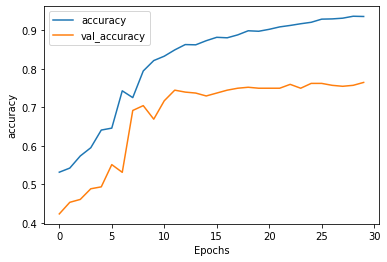

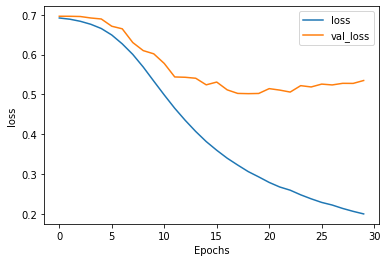

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## A hálózat vizualizálásához szükséges fájlok letöltése

Az alábbi kód segítségével ismét vizualizálhatja az összes alszóhoz kapcsolódó érzelmeket, és az adatok feltöltéséhez és megtekintéséhez a http://projector.tensorflow.org/ oldalra kell menni.

Vegye figyelembe, hogy az alábbi kódban van néhány apró változtatás, hogy kezelni tudja a szöveg kódolásának eltérő módját az adatkészletünkben, mint korábban a beépített `Tokenizerrel`.

Előfordulhat, hogy a következő hibaüzenet jelenik meg: "A tenzorok száma (999) nem egyezik a metaadatok sorainak számával (992)". Mindaddig, amíg először hiba nélkül betöltjük a vektorokat, és várunk néhány másodpercet, miután ez felugrik, a fájl betöltése menüponton kívülre kattintva továbbra is megtekinthetjük a vizualizációt.

In [16]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [17]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [19]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Lássuk ugyanezt magyar szövegeken

In [1]:
hun_sentences = ['A zsebórákból kinőtt karórákat kezdetben jellemzően a nők hordták, majd a 19. századra a férfiak is átvették a szokást. Az első világháborúban már szinte követelmény volt a repülőpilóták karóraviselése, ezután az órapiac fellendült, és a stílusos úriemberek elengedhetetlen kiegészítője lett a karóra. A kilencvenes években a mobiltelefonok elterjedésével a karórák trendje visszaesett, az új generációk már nem ezt ítélik státuszszimbólumnak, hanem a telefon márkáját.']

In [6]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(hun_sentences, vocab_size, max_subword_length=4)

In [ ]:
# Check that the tokenizer works appropriately
num = 0
print(hun_sentences[num])
encoded = tokenizer.encode(hun_sentences[num])
print(encoded)
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

#Spacy használata szövegfeldolgozáshoz

In [9]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
for token in doc:
    print(token.text, token.lemma_)

Apple Apple
is be
looking look
at at
buying buy
U.K. U.K.
startup startup
for for
$ $
1 1
billion billion
